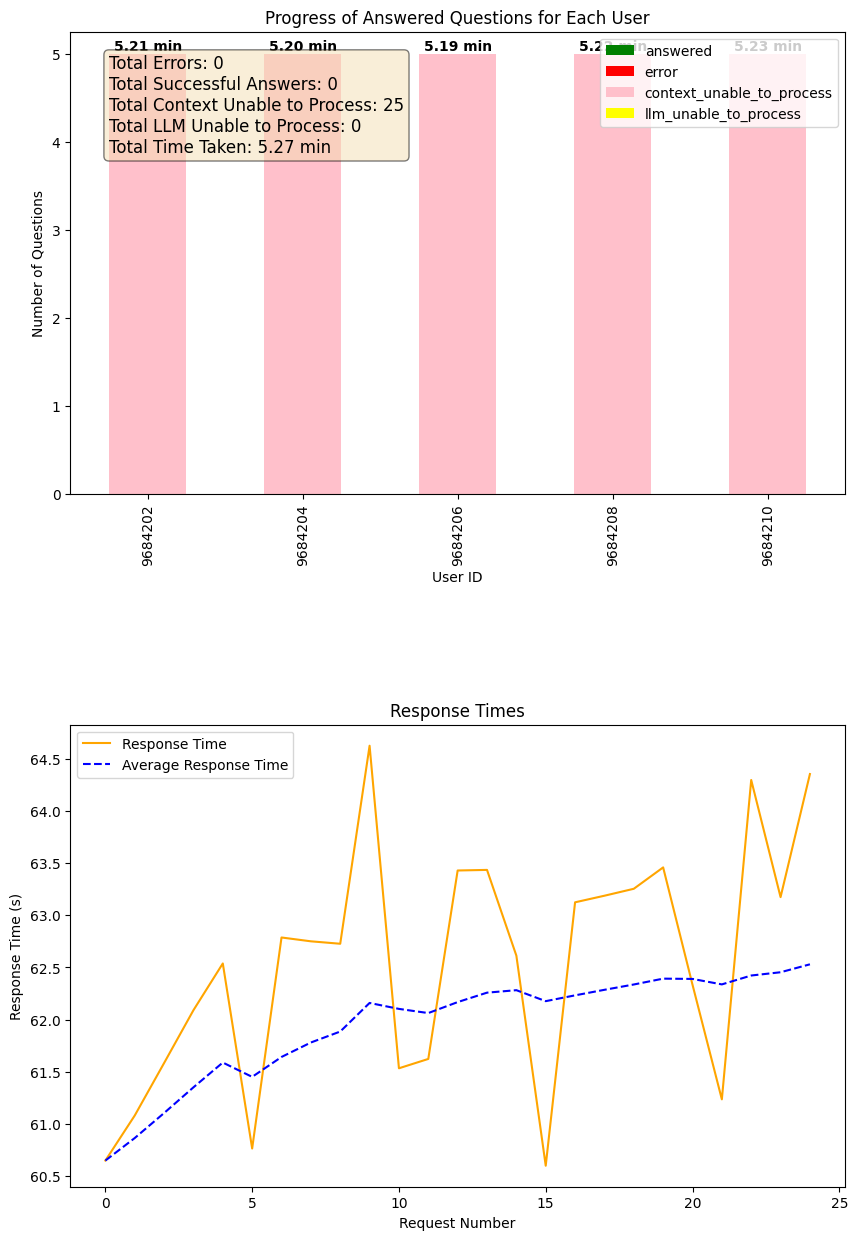

Volume testing completed with 5 users and 25 questions.


c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 0.3.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(
c:\Users\W513032\source\repos\volume testing\.venv\lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


An error occurred during analysis: Error raised by bedrock service: An error occurred (ExpiredTokenException) when calling the InvokeModel operation: The security token included in the request is expired

LLM Analysis and Recommendations:

An error occurred during analysis: Error raised by bedrock service: An error occurred (ExpiredTokenException) when calling the InvokeModel operation: The security token included in the request is expired
Results saved to volume-test-run-20240605-1841.xlsx


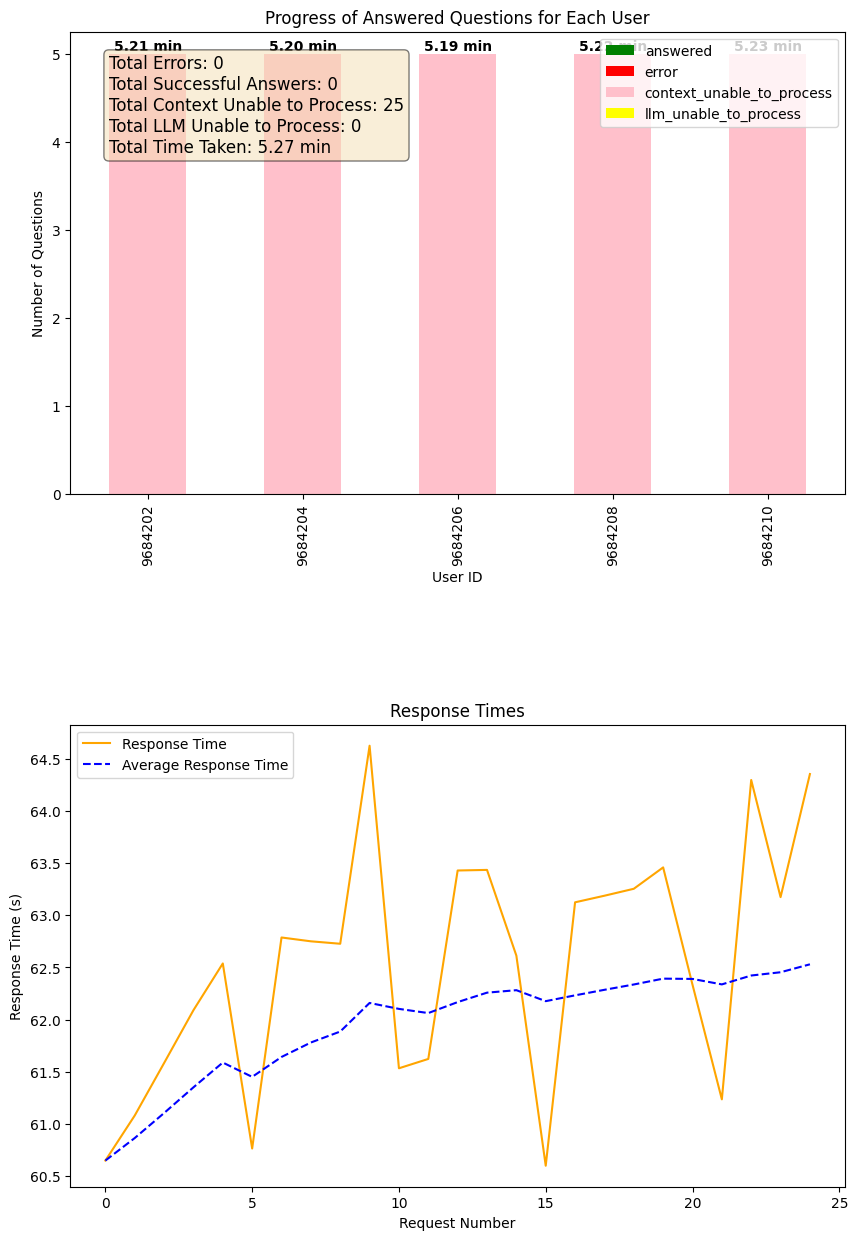

In [1]:
import os
import pandas as pd
import random
import aiohttp
import asyncio
import certifi
import matplotlib.pyplot as plt
from threading import Lock
from datetime import datetime
from langchain_community.llms import Bedrock
from langchain_aws import BedrockLLM
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
import sys
import boto3
from botocore.exceptions import NoCredentialsError, PartialCredentialsError
import json
from IPython.display import display, clear_output
import urllib3
import time
import statistics
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

os.environ["AWS_PROFILE"] = "default"
os.environ["REQUESTS_CA_BUNDLE"] = certifi.where()

# Get environment variables
AUTH_CLIENT_SECRET = os.getenv("AUTH_CLIENT_SECRET")
AUTH_URL = os.getenv("AUTH_URL")

model_id = "meta.llama3-8b-instruct-v1:0"
NUM_QUESTIONS_PER_USER = 5

import nest_asyncio
nest_asyncio.apply()

# Dictionary of special response strings
SPECIAL_RESPONSES = {
    "ContextUnableProcessMessage": "We're unable to process your request at this time.",
    "LLMUnableProcessMessage": "I am unable to respond to your message at this time."
}

def validate_file(file_path):
    try:
        df = pd.read_excel(file_path)
        return True, df.shape[0]
    except Exception as e:
        print(f"Exception occurred during file validation: {e}")
        return False, 0

async def get_token_async():
    token_request = {
        "grant_type": "client_credentials",
        "userid": "9684202",
        "tenant_id": "1130",
        "client_id": "mbe50",
        "client_secret": AUTH_CLIENT_SECRET,
        "scope": "externalidentityprovider"
    }

    async with aiohttp.ClientSession() as session:
        async with session.post("https://dv-id.mybenefitexpress.com/connect/token", data=token_request) as response:
            token_json = await response.text()
            token_data = json.loads(token_json)

            if "access_token" in token_data:
                return token_data["access_token"]
            else:
                raise Exception("Unable to retrieve access token from IdentityServer.")

async def validate_token(token):
    url = 'https://benefit-assistant.dv.mybenefitexpress.com/v1.0/benefitassistant/Session'
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    async with aiohttp.ClientSession() as session:
        try:
            async with session.get(url, headers=headers, ssl=True) as response:
                return response.status == 200
        except aiohttp.ClientError as e:
            print(f"Exception occurred during token validation: {e}")
            return False

async def retrieve_token(user_id, client_id, client_secret, auth_url):
    data = {
        "grant_type": "client_credentials",
        "userid": user_id,
        "tenant_id": client_id,
        "logged_in_tenant_id": client_id,
        "logged_in_user_id": user_id,
        "client_id": "mbe50",
        "client_secret": client_secret,
        "scope": "externalidentityprovider"
    }

    async with aiohttp.ClientSession() as session:
        try:
            async with session.post(auth_url, data=data) as response:
                response.raise_for_status()
                token_data = await response.json()

                if "access_token" in token_data:
                    return token_data['access_token'].strip("'")
                else:
                    raise Exception("Unable to retrieve access token from IdentityServer.")
        except aiohttp.ClientError as ex:
            print(f"An error occurred during authentication: {ex}")
            return None

async def chat(question, token):
    url = f'https://benefit-assistant.dv.mybenefitexpress.com/v1.0/benefitassistant/Assistant/llm-response?question={question}'
    headers = {
        'accept': '*/*',
        'Authorization': f'Bearer {token}'
    }
    async with aiohttp.ClientSession() as session:
        try:
            async with session.get(url, headers=headers, ssl=True) as response:
                response.raise_for_status()
                return await response.json()
        except aiohttp.ClientError as e:
            return {"error": str(e)}

async def simulate_user_questions(user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results, token, start_time, num_questions_per_user, fig, axes):
    combined = list(zip(question_ids, questions))
    random.shuffle(combined)
    selected_questions = random.sample(combined, min(num_questions_per_user, len(combined)))

    num_questions_answered = 0

    for question_id, question in selected_questions:
        try:
            start_time_question = datetime.now()
            response = await chat(question, token)
            end_time_question = datetime.now()
            time_taken = (end_time_question - start_time_question).total_seconds()
            user_time[user_id] += time_taken
            response_times.append(time_taken)
            avg_response_times.append(sum(response_times) / len(response_times))

            if "error" in response:
                raise Exception(response["error"])

            answer = response.get("answer", "")
            if answer == SPECIAL_RESPONSES["ContextUnableProcessMessage"]:
                user_progress[user_id]["context_unable_to_process"] += 1
            elif answer == SPECIAL_RESPONSES["LLMUnableProcessMessage"]:
                user_progress[user_id]["llm_unable_to_process"] += 1
            else:
                user_progress[user_id]["answered"] += 1

            results.append([user_id, question, answer, "", start_time_question, end_time_question])
            num_questions_answered += 1
        except Exception as e:
            error_info = f"Error occurred for user {user_id}, question ID {question_id}, question: {question}. Error: {str(e)}"
            error_log.append(error_info)
            user_progress[user_id]["error"] += 1
            results.append([user_id, question, "", str(e), start_time_question, end_time_question])

        with lock:
            update_plot(user_progress, user_time, response_times, avg_response_times, error_log, start_time, fig, axes)

    return num_questions_answered

def initialize_plot():
    fig, axes = plt.subplots(2, 1, figsize=(10, 15))
    plt.subplots_adjust(hspace=0.5)
    return fig, axes

def update_plot(user_progress, user_time, response_times, avg_response_times, error_log, start_time, fig, axes):
    progress_df = pd.DataFrame(user_progress).T

    axes[0].cla()
    progress_df.plot(kind='bar', stacked=True, color=['green', 'red', 'pink', 'yellow'], ax=axes[0])
    axes[0].set_xlabel('User ID')
    axes[0].set_ylabel('Number of Questions')
    axes[0].set_title('Progress of Answered Questions for Each User')
    axes[0].yaxis.get_major_locator().set_params(integer=True)

    for user_id, user_data in user_progress.items():
        answered_height = user_data["answered"]
        error_height = user_data["error"]
        context_unable_to_process_height = user_data["context_unable_to_process"]
        llm_unable_to_process_height = user_data["llm_unable_to_process"]
        total_height = answered_height + error_height + context_unable_to_process_height + llm_unable_to_process_height

        if total_height > 0:
            x = progress_df.index.get_loc(user_id)
            time_text = f"{user_time[user_id] / 60:.2f} min"
            axes[0].annotate(time_text, (x, total_height),
                             ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    total_time_taken = (time.time() - start_time) / 60

    total_errors = sum(user['error'] for user in user_progress.values())
    total_successes = sum(user['answered'] for user in user_progress.values())
    total_context_unable_to_process = sum(user['context_unable_to_process'] for user in user_progress.values())
    total_llm_unable_to_process = sum(user['llm_unable_to_process'] for user in user_progress.values())
    textstr = f'Total Errors: {total_errors}\nTotal Successful Answers: {total_successes}\nTotal Context Unable to Process: {total_context_unable_to_process}\nTotal LLM Unable to Process: {total_llm_unable_to_process}\nTotal Time Taken: {total_time_taken:.2f} min'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=12,
                 verticalalignment='top', bbox=props)

    axes[1].cla()
    axes[1].plot(response_times, label='Response Time', color='orange')
    axes[1].plot(avg_response_times, label='Average Response Time', linestyle='--', color='blue')
    axes[1].set_xlabel('Request Number')
    axes[1].set_ylabel('Response Time (s)')
    axes[1].set_title('Response Times')
    axes[1].legend()

    clear_output(wait=True)
    display(fig)

def analyze_results(user_count, question_count, total_successes, total_errors, total_unable_to_process, total_time_taken, avg_response_times, response_times, error_log):
    bedrock_client = boto3.client(
        service_name="bedrock-runtime",
        region_name="us-east-1",
        
    )

    llm = BedrockLLM(
        model_id=model_id,
        client=bedrock_client,
        model_kwargs={
            "max_gen_len": 1024,
            "temperature": 0.3,  # Decreased temperature for more deterministic responses
            "top_p": 0.9,  # Added top_p for more diverse responses
        }
    )

    summary_template = """
    Volume Testing Results Summary:
    - Number of users: {user_count}
    - Number of questions: {question_count}
    - Total Successful Answers: {total_successes}
    - Total Errors: {total_errors}
    - Total Unable to Process: {total_unable_to_process}
    - Total Time Taken: {total_time_taken:.2f} minutes
    - Average Response Time: {avg_response_time:.2f} seconds
    - Maximum Response Time: {max_response_time:.2f} seconds
    - Minimum Response Time: {min_response_time:.2f} seconds
    - Standard Deviation of Response Times: {std_dev_response_time:.2f} seconds

    Error Log:
    {error_log}
    """

    question_template = """
    We are testing an API. Please analyze the following volume test results and provide insights on what is good, what problems exist, and how to improve performance if there are any issues.

    {results_summary}
    """

    # Calculate standard deviation of response times
    std_dev_response_time = statistics.stdev(response_times)

    results_summary = summary_template.format(
        user_count=user_count,
        question_count=question_count,
        total_successes=total_successes,
        total_errors=total_errors,
        total_unable_to_process=total_unable_to_process,
        total_time_taken=total_time_taken,
        avg_response_time=sum(avg_response_times) / len(avg_response_times),
        max_response_time=max(response_times),
        min_response_time=min(response_times),
        std_dev_response_time=std_dev_response_time,
        error_log=error_log
    )

    question = question_template.format(results_summary=results_summary)

    prompt = PromptTemplate(
        input_variables=["question"],
        template="{question}"
    )

    try:
        bedrock_chain = LLMChain(llm=llm, prompt=prompt)
        response = bedrock_chain({'question': question})
        return response['text']
    except Exception as e:
        print(f"An error occurred during analysis: {str(e)}")
        return f"An error occurred during analysis: {str(e)}"

async def main():
    users_file_path = "wex-users.xlsx"
    questions_file_path = "wex-questions.xlsx"

    is_users_valid, user_count = validate_file(users_file_path)
    is_questions_valid, question_count = validate_file(questions_file_path)

    if not is_users_valid or not is_questions_valid:
        print("One or both of the uploaded files are not valid Excel files.")
        sys.exit(1)

    users = pd.read_excel(users_file_path)
    user_ids = users["user-id"].tolist()
    client_ids = users["client-id"].tolist()

    user_tokens = {}

    tasks = [retrieve_token(user_id, client_id, AUTH_CLIENT_SECRET, AUTH_URL) for user_id, client_id in zip(user_ids, client_ids)]
    tokens = await asyncio.gather(*tasks)

    for user_id, token in zip(user_ids, tokens):
        if token and await validate_token(token):
            user_tokens[user_id] = token
        else:
            print(f"Error: Invalid Bearer token for user {user_id}.")

    if not user_tokens:
        print("No valid tokens retrieved. Exiting...")
        sys.exit(1)

    error_log = []
    response_times = []
    avg_response_times = []
    results = []

    questions_df = pd.read_excel(questions_file_path)
    questions = questions_df["Question"].tolist()
    question_ids = questions_df["question-id"].tolist()

    user_progress = {user_id: {"answered": 0, "error": 0, "context_unable_to_process": 0, "llm_unable_to_process": 0} for user_id in user_ids}
    user_time = {user_id: 0 for user_id in user_ids}
    lock = Lock()

    fig, axes = initialize_plot()
    display(fig)

    start_time = time.time()

    tasks = [
        simulate_user_questions(user_id, questions, question_ids, user_progress, user_time, response_times, avg_response_times, error_log, lock, results, token, start_time, NUM_QUESTIONS_PER_USER, fig, axes)
        for user_id, token in user_tokens.items()
    ]
    num_questions_answered_list = await asyncio.gather(*tasks)

    total_questions_answered = sum(num_questions_answered_list)

    total_time_taken = (time.time() - start_time) / 60

    print(f"Volume testing completed with {user_count} users and {total_questions_answered} questions.")
    if error_log:
        print("Errors occurred during volume testing. Here are the details:")
        for error in error_log:
            print(error)

    try:
        total_successes = sum(user['answered'] for user in user_progress.values())
        total_errors = sum(user['error'] for user in user_progress.values())
        total_unable_to_process = sum(user['context_unable_to_process'] for user in user_progress.values()) + sum(user['llm_unable_to_process'] for user in user_progress.values())
        analysis = analyze_results(len(user_ids), total_questions_answered, total_successes, total_errors, total_unable_to_process, total_time_taken, avg_response_times, response_times, error_log)
        print("\nLLM Analysis and Recommendations:\n")
        print(analysis)
    except Exception as e:
        print(f"An error occurred during analysis: {str(e)}")

    results_df = pd.DataFrame(results, columns=['user-id', 'question', 'answer', 'error', 'start_time', 'end_time'])
    results_df['start_time'] = results_df['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    results_df['end_time'] = results_df['end_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    timestamp = datetime.now().strftime('%Y%m%d-%H%M')
    results_df.to_excel(f'volume-test-run-{timestamp}.xlsx', index=False)
    print(f"Results saved to volume-test-run-{timestamp}.xlsx")

# Run the main function
await main()

